## Simple Linear Regression

In [2]:
from pathlib import Path
import random

import pandas as pd
import numpy as np
import pylab
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import weightstats
from statsmodels.stats import proportion
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import t

import matplotlib.pyplot as plt
%matplotlib inline

### Session Time (Mean) Estimation

In [3]:
# 평균 session time이 길어야 160초이고, 이를 늘리기 위해 새로운 웹 프레젠테이션이 필요하다고 주장한다면?

data_path = './data/'

session_times = pd.read_csv(data_path + 'web_page_data.csv')
session_times.Time = 100 * session_times.Time # 초 단위로 변환

session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


In [4]:
session_times.Time.mean(), session_times.Time.std()

(141.19444444444446, 94.24067045736659)

In [5]:
# confidence interval = t분포 하의 신뢰구간 (유의수준 설정)
stat = weightstats.DescrStatsW(session_times.Time)
stat.tconfint_mean(alpha=0.05)

(109.30798906792316, 173.08089982096575)

### 가설검정

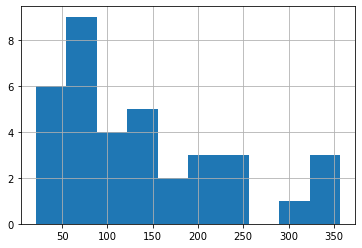

In [6]:
# One sample t-test를 위한 가정 체크
# → 자료가 정규분포를 따른다거나, 심하게 편중되거나 극단치가 포함되는 경우, 표본 수가 50(혹은 30)개 이상

session_times.Time.hist()
plt.show()

#### 검정통계량과 P-value의 계산  
    - 귀무가설이 참이라고 가정할 때 아래의 T-통계량은 자유도 n-1을 가지는 t분포를 따름  
$$ T-statistics =\frac{\bar x - \mu_0 }{s/\sqrt n } \sim t_{n-1}$$  

In [7]:
# One Sample T-test
# 귀무가설이 참이라고 가정할 때, T 통계량은 자유도 n-1을 갖는 T 분포를 따름

t_result = stat.ttest_mean(value = 160, alternative='smaller')
print('T_statistics: %.3f, p-value: %.3f, degrees of freedom: %i' %(t_result))

T_statistics: -1.197, p-value: 0.120, degrees of freedom: 35


In [8]:
ad = pd.read_csv(data_path + 'Advertising.csv')
ad.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


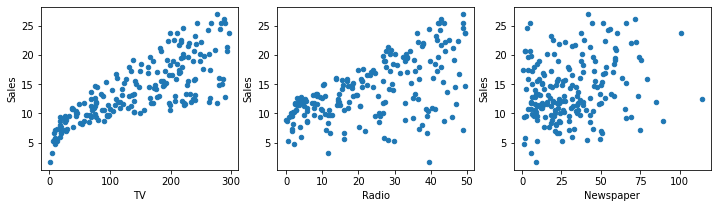

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
ad.plot.scatter('TV', 'Sales', ax = axes[0])
ad.plot.scatter('Radio', 'Sales', ax = axes[1])
ad.plot.scatter('Newspaper', 'Sales', ax = axes[2])
plt.show()

In [10]:
# 최소제곱법(LSE)을 활용한 회귀선 적합과 통계량 확인

model = smf.ols('Sales ~ TV', data = ad).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           1.47e-42
Time:                        02:19:32   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# 유의수준 0.05 아래에서 회귀계수에 대한 95% 신뢰구간

model.conf_int(alpha=0.05)

,0,1
Intercept,6.129719,7.935468
TV,0.042231,0.052843


-  광고를 전혀 하지 않으면 평균 판매량은 [6130, 7940] 사이의 값으로 떨어진다 
- TV광고 투자가 매 1천달러 증가할 경우 판매량은 평균 [42, 53] 사이의 값만큼 증가한다.
&nbsp;

In [12]:
# 회귀 모형의 설명력 확인을 위한 통계치
model.rsquared

0.611875050850071

- sales의 변동 중 61%가 TV에 대한 선형회귀에 의해 설명된다. 
- 단순선형회귀에서는 $R^2$는 피어슨 상관계수의 제곱과 같다.

In [13]:
# Sales와 TV의 선형회귀에 따른 상관계수
stats.pearsonr(ad.Sales,ad.TV)[0]**2

0.6118750508500714

### 1.2.5 예측
- 주어진 독립변수에 대한 종속변수의 값을 추정된 회귀식에 의해 예측한다.

$$\hat y= \hat \beta_0 + \hat \beta_1 x^*  $$

In [14]:
# 새로운 독립변수에 대한 예측치
pred = model.get_prediction(exog = dict(TV=100))
pred.summary_frame(alpha = 0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,11.786258,0.262897,11.26782,12.304695,5.339251,18.233264


#### 신뢰구간 
- 수많은 도시에 대한 **평균** 판매량을 둘러싼 불확실성을 수량화
- TV광고에 10만달러를 지출한다면 판매량의 평균은 11268개와 12305개 사이일 것으로 95% 확신함


#### 예측구간
- **특정** 도시의 판매량에 대한 불확실성을 수량화
- TV광고에 10만달러를 지출한 도시에서 판매량은 5339개와 18233개 사이일 것으로 95% 확신함  
- 회귀식은 가지고 있는 데이터 범위 밖에서 예측은 주의 (Extrapolation Problem)

### 단순선형회귀모형 실습

1. 대한민국의 50원 짜리 동전의 무게는 4.16 그램으로 정해져 있다. 15개의 표본 동전을 선택하여 측정한 결과 평균 무게는 4.02 그램이고 표준편차는 0.040그램이다. (표본 무게의 분포가 대칭의 형태라고 가정하자.) 평균무게가 정해진 기준보다 작다고 5% 유의수준에서 말할 수 있는가? 가설검정 과정을 통해 답하시오.

In [15]:
# 단일표본 평균에 대한 검정 = One sample t-test
# 표본 무게의 분포가 대칭 형태이므로 One sample t-test의 가정을 만족
T = (4.02 - 4.16) / (0.040 / np.sqrt(15))
T

-13.555441711726013

In [16]:
stats.t.cdf(T, 14) # 어떤 값보다 작을 확률을 계산해주는 함수 # 뒷 파라미터는 자유도 n-1

9.639968342159571e-10

2. `airbnb.csv` 데이터셋을 사용하여 샌프란시스코 전체 리스팅의 `reviews_per_month`의 평균을 99% 신뢰구간으로 추정하고 해석하시오. 

In [18]:
data = pd.read_csv("./data/airbnb.csv")
data.reviews_per_month

0       1.77
1       1.33
2       0.87
3       0.15
4       0.13
        ... 
6100    1.00
6101    1.00
6102    1.00
6103    1.00
6104    0.23
Name: reviews_per_month, Length: 6105, dtype: float64

In [19]:
stat = weightstats.DescrStatsW(data.reviews_per_month)
# 99% 신뢰구간
stat.tconfint_mean(alpha=0.01)

(1.8193320137107718, 1.9571692147904565)

In [20]:
# 95% 신뢰구간
stat.tconfint_mean(alpha=0.05)

(1.835816037911687, 1.9406851905895413)

3. `houseprice.csv`는 주택판매가격(price)과 이에 영향을 줄 것으로 판단되는 4가지 설명변수인 세금(tax; 만원), 대지평수(ground; 평), 건물평수(floor; 평), 주택연령(year; 년)을 27개 주택에 대해 조사한 것이다. 

In [21]:
data = pd.read_csv("./data/houseprice.csv")
data.head()

,price,tax,ground,floor,year
0,12.95,98.352,34.72,19.96,4.2
1,14.75,100.416,35.31,30.00,6.2
2,13.95,90.858,22.75,23.50,4.0
3,12.95,91.146,40.50,24.64,5.4
4,14.95,101.194,44.55,22.42,4.2


(a)  주택 가격과 세금 간의 산점도 행렬과 상관계수를 구하시오. 두 변수 간의 선형관계가 존재하는가? 산점도 행렬을 보면 3개의 특이한 관측치가 나타난다. 이들 값의 특성은 무엇인가?

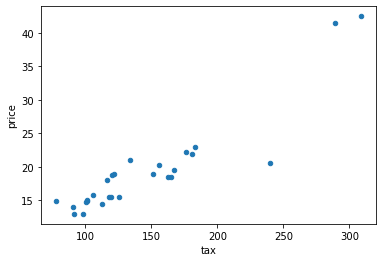

In [22]:
data.plot.scatter('tax', 'price') # = data.plot(x="tax", y="price", kind="scatter")
plt.show()

In [23]:
# 피어슨 상관계수는 선형관계의 강도를 나타내므로, 산점도 행렬을 함께 관찰해야 한다
data.corr()

,price,tax,ground,floor,year
price,1.000000,0.915249,0.726335,0.928827,-0.310290
tax,0.915249,1.000000,0.686850,0.832415,-0.371172
ground,0.726335,0.686850,1.000000,0.703269,-0.380275
floor,0.928827,0.832415,0.703269,1.000000,-0.178057
year,-0.310290,-0.371172,-0.380275,-0.178057,1.000000


In [24]:
data[data.tax > 200]

,price,tax,ground,floor,year
8,42.45,308.404,98.0,68.4,4.2
9,41.45,289.196,128.0,60.0,1.4
26,20.50,240.000,50.0,24.0,3.0


(b) 주택 가격을 종속변수로 하고 세금을 설명변수로 하는 단순선형회귀모형을 적합하여 적합된 회귀식을 쓰시오. 

In [25]:
model = smf.ols('price ~ tax', data = data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     129.0
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           2.31e-11
Time:                        02:25:45   Log-Likelihood:                -66.382
No. Observations:                  27   AIC:                             136.8
Df Residuals:                      25   BIC:                             139.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7907      1.556      1.794      0.085      -0.413       5.994
tax            0.1136      0.010     11.359      0.000       0.093       0.134
==============================================================================
Omnibus:                       11.576   Durbin-Watson:                   1.335
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.951
Skew:                          -0.909   Prob(JB):                     0.000935
Kurtosis:                       6.016   Cond. No.                         428.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(c) tax의 계수에 대한 95% 신뢰구간을 계산하고 해석하시오. 

In [26]:
# y_hat = 2.7907 + 0.1136 * tax
model.conf_int(alpha=0.05)
# tax가 없을 경우,houseprice는 -4129~59944 사이에 존재한다
# tax가 만원 상승할 때마다, houseprice는 929~1341 증가한다

,0,1
Intercept,-0.412993,5.994431
tax,0.092995,0.134188


(d) tax의 계수에 대한 가설검정을 진행하시오. 

H0 : beta_1 = 0  
H1 : beta_1 != 0  
→ H0를 기각

(e) 모형의 R-square는 몇 인가? 그것의 의미는 무엇인가?

In [28]:
model.rsquared
# 83.8% 만큼 tax가 price의 변동성을 설명함 

0.8376815840383705

(f) tax가 중위수인 집의 가격을 예측하려고 한다. 신뢰구간과 예측구간을 구하고 각 구간의 의미를 해석하시오. 

In [29]:
pred = model.get_prediction(exog = dict(tax=data.tax.median()))
pred.summary_frame(alpha = 0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,16.633213,0.610771,15.375306,17.891119,10.450429,22.815996
